In [395]:
# import the appropriate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from scipy import stats
from collections import Counter
import re
from datetime import datetime
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
from io import BytesIO
import ast
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

#image analysis: first install dlib in your ada environment (1: conda activate ada , 2: install dlib)
import dlib 
#face recognition library, first install it in your ada environment (1: conda activate ada, 2: install face_recognition)
import face_recognition
from PIL import Image, ImageDraw

>In this part we want to extract actors' facial encodings, in order to use them as features for classification. We are using the *actor_images.csv* file that we've created. It contains actor names, their correspoding pictures stored as a url with it's width and height. The code for that file can be found in the *people_images.ipynb* notebook.   

In [396]:
#Loads "actor_images.csv" file
actor_images = pd.read_csv('data/our_datasets/actor_images.csv')
actor_images.head()

,Actor,Image URL,Image height,Image width
0,Dustin Hoffman,https://image.tmdb.org/t/p/original/yFjTzJHE6A...,900,600
1,Edward Norton,https://image.tmdb.org/t/p/original/5XBzD5WuTy...,771,514
2,David Krumholtz,https://image.tmdb.org/t/p/original/6M2kk44Z1D...,1680,1120
3,Matthew Broderick,https://image.tmdb.org/t/p/original/papqFgpyro...,900,600
4,Ronny Cox,https://image.tmdb.org/t/p/original/cKkVkqft2R...,2000,1334


In [397]:
#Finding missing values 
missing = actor_images == '-'
missing_images = actor_images[missing.any(axis=1)]
print(missing_images)

             Actor Image URL Image height Image width
69   Trevor Thomas         -          Nan         Nan
215  Peter Hinwood         -          Nan         Nan
324      Shih Kien         -          Nan         Nan


>Only 0.85% of the data is missing. We will disregard it for now as it is marginal

In [398]:
#actor_images without the missing urls
actor_cleaned = actor_images[~missing.any(axis=1)]

In [399]:
actor_test = actor_cleaned[:5]

In [400]:
'''
def landmarks(row):


    actor_name = row['Actor']
    image_url = row['Image URL']

    try:
        # Retrieve image URL
        img = requests.get(image_url)
        image_content = BytesIO(img.content)

        # Transform the image into an array
        img_array = np.asarray(Image.open(image_content))

        # Extract facial encodings (coordinates)
        face_landmarks_list = face_recognition.face_landmarks(img_array)
        
        if face_landmarks_list:
            face_encodings_list = face_recognition.face_encodings(img_array)
                                                                  
        else:
            face_encodings_list = np.nan

    except Exception as e:
        face_landmarks_list = np.nan
        face_encodings_list = np.nan
        
    return pd.Series({'Actor': actor_name, 'Landmarks': face_landmarks_list, 'Encodings':face_encodings_list})

'''
    
#face_encodings = actor_cleaned.apply(lambda row: landmarks(row), axis=1)

"\ndef landmarks(row):\n\n\n    actor_name = row['Actor']\n    image_url = row['Image URL']\n\n    try:\n        # Retrieve image URL\n        img = requests.get(image_url)\n        image_content = BytesIO(img.content)\n\n        # Transform the image into an array\n        img_array = np.asarray(Image.open(image_content))\n\n        # Extract facial encodings (coordinates)\n        face_landmarks_list = face_recognition.face_landmarks(img_array)\n        \n        if face_landmarks_list:\n            face_encodings_list = face_recognition.face_encodings(img_array)\n                                                                  \n        else:\n            face_encodings_list = np.nan\n\n    except Exception as e:\n        face_landmarks_list = np.nan\n        face_encodings_list = np.nan\n        \n    return pd.Series({'Actor': actor_name, 'Landmarks': face_landmarks_list, 'Encodings':face_encodings_list})\n\n"

In [401]:
face_encodings = pd.read_csv("encodings2.csv")

In [402]:
face_encodings

,Actor,Landmarks,Encodings
0,Dustin Hoffman,"[{'chin': [(141, 392), (141, 434), (141, 477),...","[array([ 0.0167025 , 0.12338186, -0.03214089,..."
1,Edward Norton,"[{'chin': [(123, 323), (131, 358), (141, 391),...","[array([-0.00984838, 0.17413326, 0.10402523,..."
2,David Krumholtz,"[{'chin': [(226, 713), (238, 803), (253, 892),...","[array([-0.18904248, 0.11554453, 0.05453956,..."
3,Matthew Broderick,"[{'chin': [(132, 373), (138, 413), (144, 453),...","[array([-1.50219575e-01, 1.07419252e-01, 9.2..."
4,Ronny Cox,"[{'chin': [(270, 723), (249, 839), (236, 953),...","[array([-0.08915272, 0.10389782, 0.07653827,..."
...,...,...,...
342,John Hurt,"[{'chin': [(124, 314), (134, 370), (145, 424),...","[array([-3.67913246e-02, 6.23679087e-02, 8.8..."
343,Schuyler Fisk,"[{'chin': [(137, 227), (136, 254), (137, 281),...","[array([-0.06277083, 0.18962337, 0.10137066,..."
344,Laura San Giacomo,"[{'chin': [(224, 632), (229, 706), (236, 778),...","[array([-0.04032209, 0.10792185, 0.02799416,..."
345,Colin Firth,"[{'chin': [(374, 1248), (391, 1382), (416, 150...","[array([-1.13490149e-01, 4.34614718e-02, 3.6..."


In [403]:
def string_to_array(row):
    row_cleaned = row.replace('\n', '').replace('  ','').replace(' ','').replace('array','').replace('[','').replace(']','').replace('(','').replace(')','')
    return np.asarray(ast.literal_eval(row_cleaned))

In [404]:
face_encodings_cleaned = face_encodings.dropna()
missing =(len(face_encodings)-len(face_encodings_cleaned))/len(face_encodings)
print('Number of missing encodings is {:%}'.format(missing))


Number of missing encodings is 12.103746%


In [405]:
#Reset the row index as rows with missing values where removed
face_encodings_cleaned.reset_index(drop=True, inplace=True)

In [406]:
# As the dataframe was imported from a csv file, we need to make sure that the columns have the proper type 

face_encodings_cleaned['Landmarks']= face_encodings_cleaned['Landmarks'].apply(ast.literal_eval)
face_encodings_cleaned['Encodings'] = face_encodings_cleaned['Encodings'].apply(string_to_array)

/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/146970410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['Landmarks']= face_encodings_cleaned['Landmarks'].apply(ast.literal_eval)
/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/146970410.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['Encodings'] = face_encodings_cleaned['Encodings'].apply(string_to_array)


In [407]:
len(face_encodings_cleaned['Encodings'])

305

In [408]:
#Check whether each row of the Encodings column contains only one array of encodings. Each row should have exactly 128 encodings:
l_encodings = 128
for i in range(0,305):
    if len(face_encodings_cleaned['Encodings'].iloc[i]) > l_encodings:
        row = face_encodings_cleaned['Encodings'].iloc[i]
        length = len(row)
        print('Row number {} has {} encoding vectors'.format(i,length))
        #remove the additional encodings
        face_encodings_cleaned['Encodings'].iloc[i] = row[:128]

Row number 97 has 256 encoding vectors
Row number 131 has 256 encoding vectors
Row number 156 has 256 encoding vectors


/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/3548799357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['Encodings'].iloc[i] = row[:128]
/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/3548799357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['Encodings'].iloc[i] = row[:128]
/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/3548799357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

>Having extracted the facial encodings for each actor, we want to retrieve features that we will use for classification. For the sake of comparison between actors, we will use proportions of certain landmarks with respect to two reference measures: one for face width (distance betweem the temples) and one for the face length (distance between the top of the nose bridge and the lowest point of the chin). For exemple, we will not look at the length of a nose, but as its size in proportion to the reference length. <br>
>For this milestone, we are only focussing on three features: nose length and width and distance between eyes. More features will be extracted for the final analysis. 

In [409]:
def face_proportions(row):

    facial_prop = pd.Series({
        'Actor': row['Actor'],
        'Eye Distance': np.nan,
        'Eye Position': np.nan,
        'Nose Length': np.nan,
        'Nose Width': np.nan,
        'Eyebrow Length': np.nan,
        'Face Shape': np.nan,
        'Cheek Bones': np.nan})
 
    try:
        landmarks = row['Landmarks'][0] 
    except (json.JSONDecodeError, IndexError):
        # Handle cases where 'Encodings' is not a valid JSON or the list is empty
        return facial_prop

    chin_landmarks = landmarks['chin']
    nose_landmarks = landmarks['nose_bridge']
    nose_width_landmarks = landmarks['nose_tip']
    left_eyebrow_landmarks = landmarks['left_eyebrow']
    right_eyebrow_landmakrs = landmarks['right_eyebrow']
    left_eye_landmarks = landmarks['left_eye']
    right_eye_landmarks = landmarks['right_eye']
    top_lip_landmarks = landmarks['top_lip']

    if not chin_landmarks or not nose_landmarks:
        return facial_prop

    #Get the maximum distance for x and y => we will standardize the distances by dividing them by the max values 
    x1 = chin_landmarks[0][0]
    x2 = chin_landmarks[-1][0]
    y1 = nose_landmarks[0][1]
    y2 = chin_landmarks[8][1]

    x_max = np.abs(x2 - x1)
    y_max = np.abs(y2 - y1)

    #Get Eye Distance
    #Eye Position: distance between the eyes and the edge of the chin (in y distance)
    if not left_eye_landmarks or not right_eye_landmarks:
        eye_dist = np.nan
        eye_position = np.nan
    else: 
        x_r = right_eye_landmarks[0][0]
        x_l = left_eye_landmarks[3][0]
        eye_dist = abs(x_r - x_l) / x_max

        y_r = right_eye_landmarks[0][1]
        y_l = left_eye_landmarks[3][1]
        chin_r = chin_landmarks[7][1]
        chin_l = chin_landmarks[9][1]

        eye_position = (abs(y_r - chin_r)/y_max + abs(y_l - chin_l)/y_max)/2


    facial_prop['Eye Distance'] = eye_dist
    facial_prop['Eye Position'] = eye_position 



    # Get nose withd and nose length
    if not nose_landmarks or not nose_width_landmarks:
        nose_length  = np.nan
        nose_width  = np.nan
    else:
        y_nose1 = nose_landmarks[0][1]
        y_nose2 = nose_width_landmarks[-1][1]
        x_nose1 = nose_width_landmarks[0][0]
        x_nose2 = nose_width_landmarks[-1][0]

        nose_length = abs(y_nose2 - y_nose1) / y_max
        nose_width = abs(x_nose2 - x_nose1) / x_max

    facial_prop['Nose Length'] = nose_length
    facial_prop['Nose Width'] = nose_width


    #Eye brow length: do for both eye brows and take the mean
    if not left_eyebrow_landmarks or not right_eyebrow_landmakrs:
        eyebrow_length = np.nan
    else: 
        x1_eyebrowl = left_eyebrow_landmarks[0][0]
        x2_eyebrowl = left_eyebrow_landmarks[-1][0]
        x1_eyebrowr = right_eyebrow_landmakrs[0][0]
        x2_eyebrowr = right_eyebrow_landmakrs[-1][0]
        eyebrow_length = (abs(x2_eyebrowl - x1_eyebrowl)/x_max + abs(x2_eyebrowr - x1_eyebrowr)/x_max)/2

    facial_prop['Eyebrow Length'] = eyebrow_length

    #Face shape: for the face shape, we will do face width on face length ratio . if close to 1 the face is square, if close to zero the face is long and narrow and if bigger than 1 the face is short and broad.
    face_shape = x_max / y_max
    facial_prop['Face Shape'] = face_shape

    # Cheek bones: x distance from chin[0] to chin[5]
    chin5 = chin_landmarks[5][0]
    chin11 = chin_landmarks[11][0]
    cheek_bones = (abs(chin5 - x1)/x_max + abs(chin11 - x2)/x_max)/2

    facial_prop['Cheek Bones'] = cheek_bones

    return facial_prop

In [410]:
facial_proportions =face_encodings_cleaned.apply(face_proportions, axis=1)

>**Features visualisation** Now that we have obtained the features (proportions of different disctinctives facial features, such as nose length, distance between eyes, etc..)

/Users/izapomykalska/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:1544: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=color, **plot_kwargs)
/Users/izapomykalska/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:1544: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad63

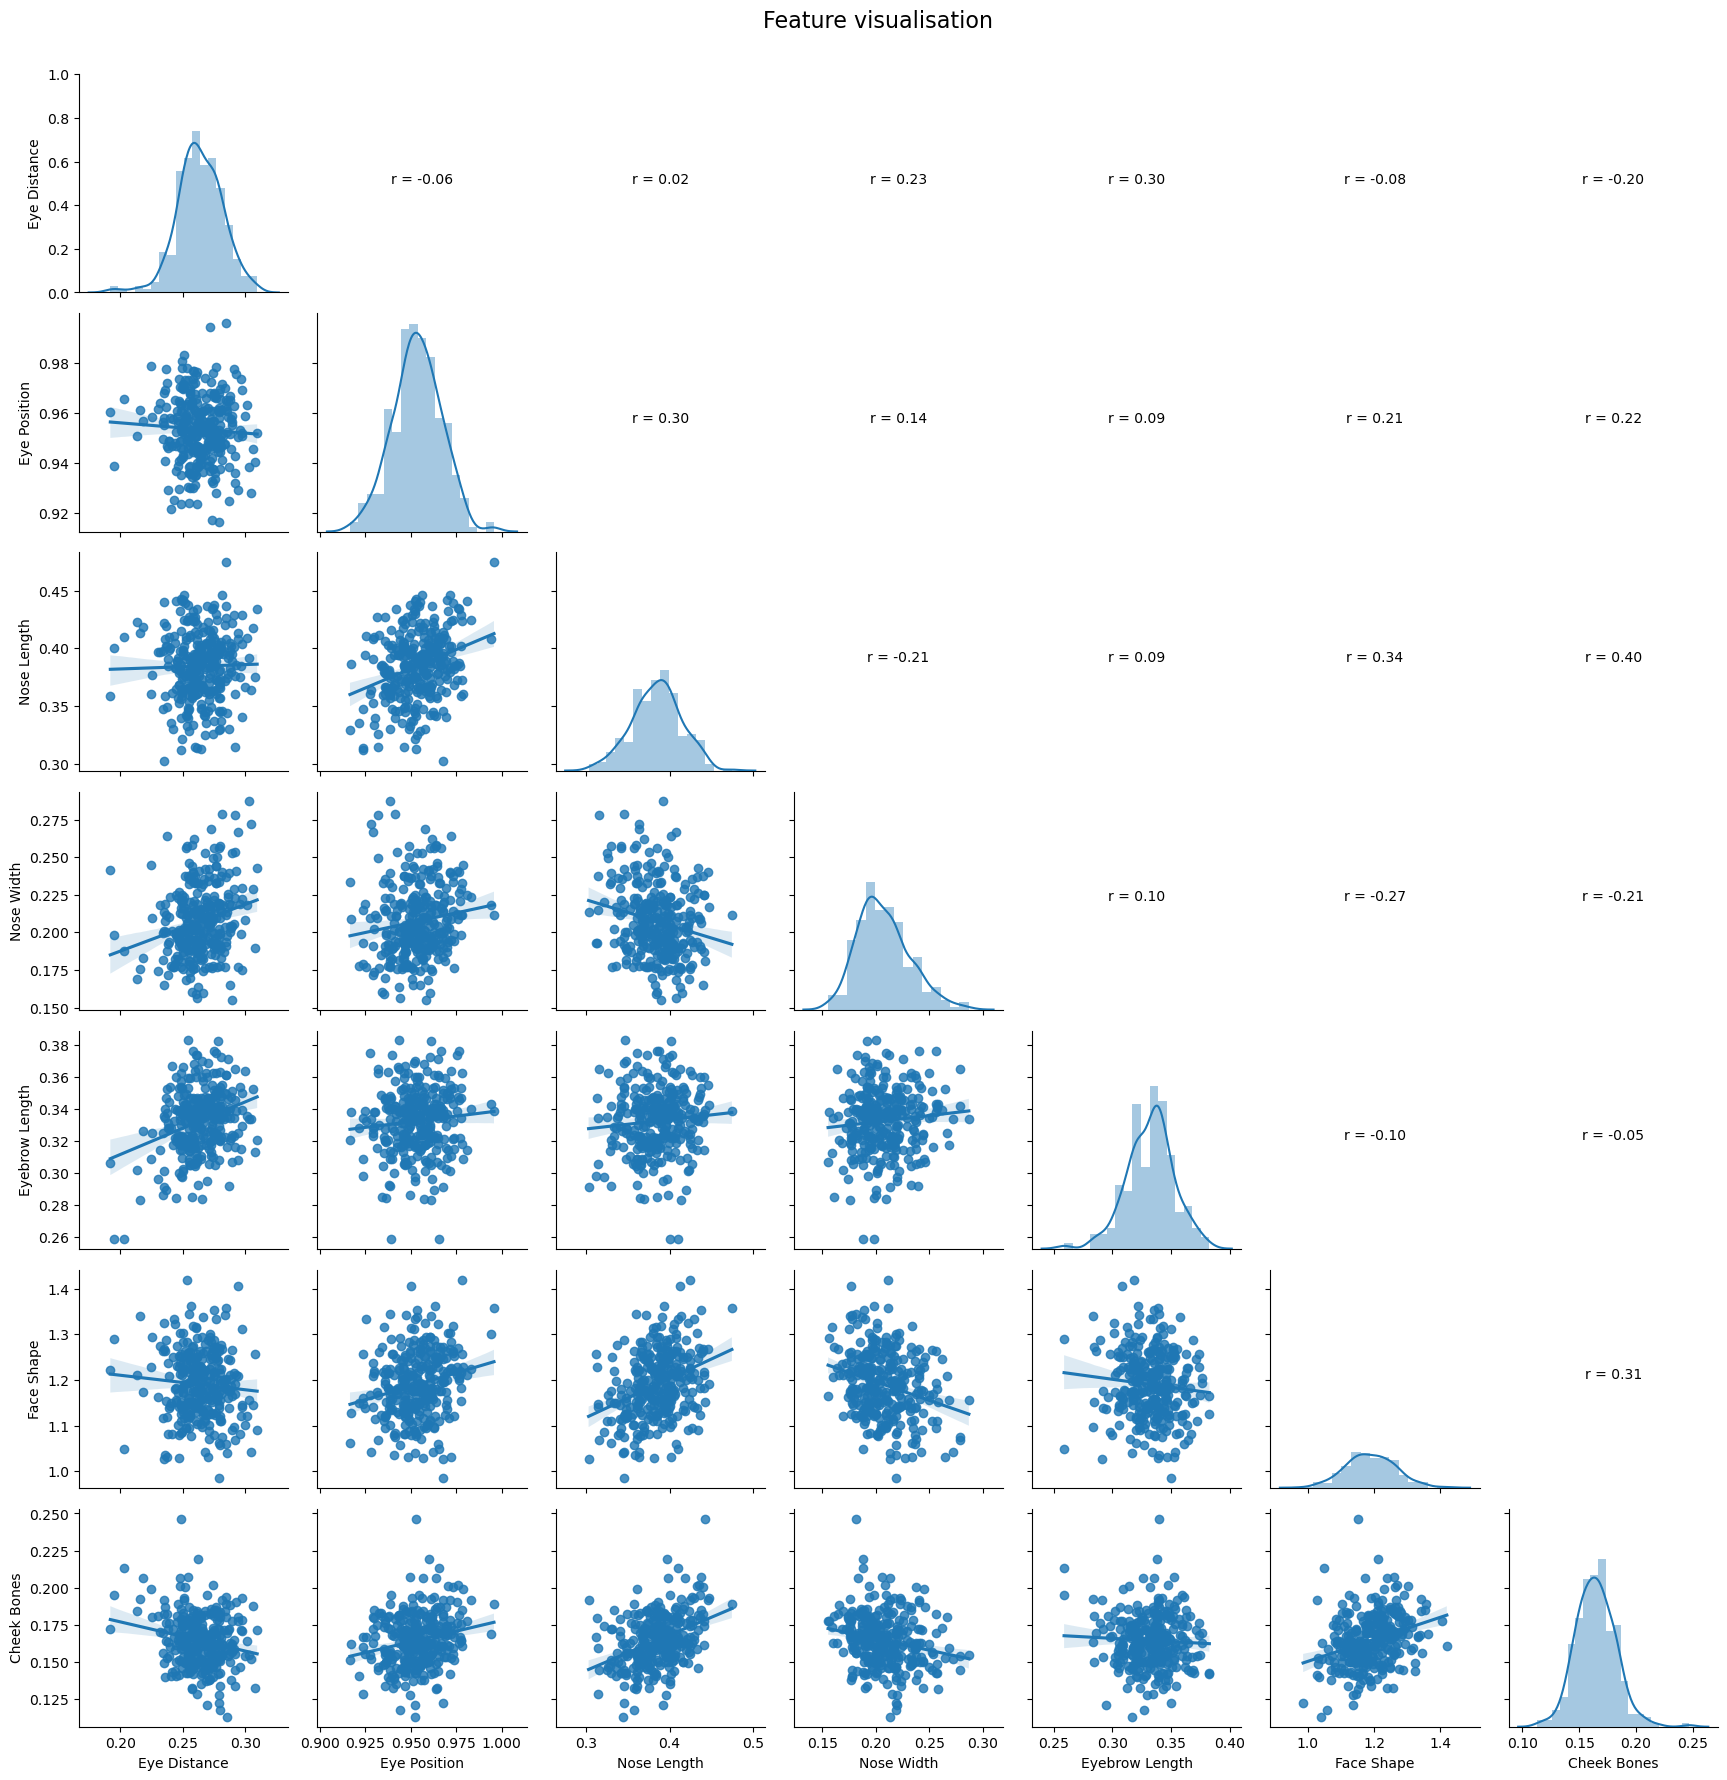

In [411]:
feature_columns = facial_proportions.drop('Actor', axis =1)
feature_columns = feature_columns.dropna()

def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
# Create the pairplot
g = sns.PairGrid(feature_columns)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

plt.suptitle('Feature visualisation', y=1.02, size=16)

plt.show()

> We observe that the nose length is normally distributed, whereas the eye distance and nose width are skewed to the right and left, respectively.Eye distance and Nose length are not correlated, Nose width and Eye distance are weakly positively correlated, and Nose width and Nose length are weakly negatively correlated. This means that we can consider those three parameters as independant of each other and use them for our analysis as such.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


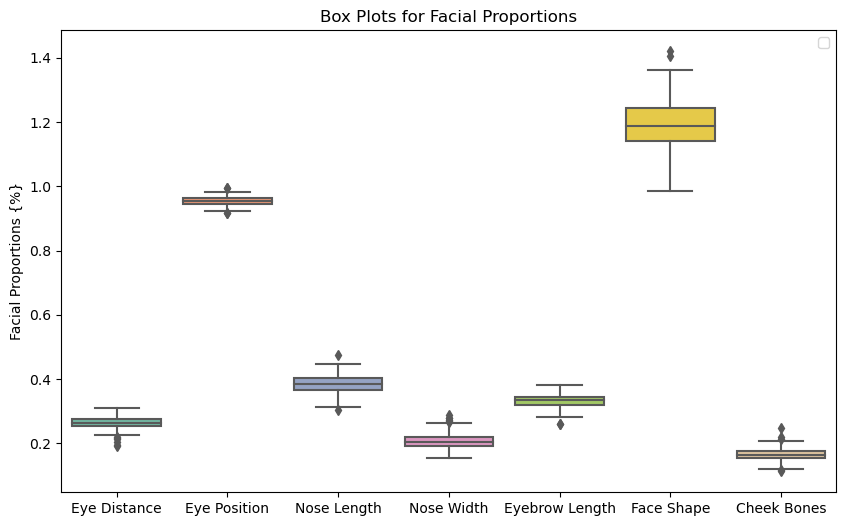

In [412]:
#Creates a boxplot for each face proportion
plt.figure(figsize=(10, 6))
sns.boxplot(data=feature_columns, palette='Set2')
plt.title('Box Plots for Facial Proportions')
plt.ylabel('Facial Proportions {%}')
plt.legend()
plt.show()

>The box plots allow us to visualise outliers . Discarding feature outliers can improve model accuracy

>For each graph, from top to bottom we have : upper outliers (dots), maximum value (first plain line), third quantile (first box line), median (middle box line), first quantile (last box line), minimum value (last plain line), lower outliers (dots)

In [413]:
#merge tropes_characters_ethnicity_df with facial_proportions
''' 
facial_proportions= facial_proportions.rename(columns={'Actor': 'ActorName'})
tropes = tropes_characters_ethnicity_df[['Trope','ActorName']]
tropes_facial_features = tropes.merge(facial_proportions, on=['ActorName'], how='outer')

'''


" \nfacial_proportions= facial_proportions.rename(columns={'Actor': 'ActorName'})\ntropes = tropes_characters_ethnicity_df[['Trope','ActorName']]\ntropes_facial_features = tropes.merge(facial_proportions, on=['ActorName'], how='outer')\n\n"

In [414]:
#tropes_facial_features_plot = tropes_facial_features.drop('ActorName',axis=1)

In [415]:
#df_melted = pd.melt(tropes_facial_features_plot, id_vars='Trope', var_name='Feature', value_name='Values')

In [416]:
'''
plt.figure(figsize=(20, 6))
sns.barplot(x='Trope', y='Values', hue='Feature', data=df_melted)
plt.xlabel('Trope')
plt.ylabel('Values')
plt.title('Bar Plot for facial features grouped by character tropes')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
'''


"\nplt.figure(figsize=(20, 6))\nsns.barplot(x='Trope', y='Values', hue='Feature', data=df_melted)\nplt.xlabel('Trope')\nplt.ylabel('Values')\nplt.title('Bar Plot for facial features grouped by character tropes')\nplt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nplt.show()\n"

**Euclidean distance for each actor pair**

In [417]:
def euclidean_dist(encoding):
    rows = face_encodings_cleaned['Encodings'].to_list()
    return face_recognition.api.face_distance(rows,encoding)

In [418]:
face_encodings_cleaned['Dist'] = face_encodings_cleaned['Encodings'].apply(euclidean_dist)

/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/1033134078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['Dist'] = face_encodings_cleaned['Encodings'].apply(euclidean_dist)


In [419]:
face_encodings_cleaned

,Actor,Landmarks,Encodings,Dist
0,Dustin Hoffman,"[{'chin': [(141, 392), (141, 434), (141, 477),...","[0.0167025, 0.12338186, -0.03214089, -0.097552...","[0.0, 0.7597780900735246, 0.8506495025476984, ..."
1,Edward Norton,"[{'chin': [(123, 323), (131, 358), (141, 391),...","[-0.00984838, 0.17413326, 0.10402523, -0.03740...","[0.7597780900735246, 0.0, 0.7991824110587352, ..."
2,David Krumholtz,"[{'chin': [(226, 713), (238, 803), (253, 892),...","[-0.18904248, 0.11554453, 0.05453956, -0.07815...","[0.8506495025476984, 0.7991824110587352, 0.0, ..."
3,Matthew Broderick,"[{'chin': [(132, 373), (138, 413), (144, 453),...","[-0.150219575, 0.107419252, 0.0921164304, 0.02...","[0.8059989608389175, 0.7265312712536373, 0.783..."
4,Ronny Cox,"[{'chin': [(270, 723), (249, 839), (236, 953),...","[-0.08915272, 0.10389782, 0.07653827, -0.03823...","[0.6965205410734864, 0.7966506384400479, 0.853..."
...,...,...,...,...
300,Mike White,"[{'chin': [(153, 295), (155, 335), (158, 374),...","[-0.00843485, 0.03790406, 0.01708604, 0.036317...","[0.7538032156147387, 0.8093517668654688, 0.828..."
301,John Hurt,"[{'chin': [(124, 314), (134, 370), (145, 424),...","[-0.0367913246, 0.0623679087, 0.0889517516, 0....","[0.7759252789658765, 0.7755372423258606, 0.866..."
302,Schuyler Fisk,"[{'chin': [(137, 227), (136, 254), (137, 281),...","[-0.06277083, 0.18962337, 0.10137066, -0.02115...","[0.954591427090049, 0.8648189601829832, 1.0179..."
303,Laura San Giacomo,"[{'chin': [(224, 632), (229, 706), (236, 778),...","[-0.04032209, 0.10792185, 0.02799416, -0.05517...","[0.9740874678520373, 0.9304774646122245, 0.923..."


In [420]:

face_encodings_cleaned['ActorID'] = face_encodings_cleaned.index

/var/folders/j5/675b54vd14xg6qwckgcfpt9w0000gn/T/ipykernel_35826/3894967953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['ActorID'] = face_encodings_cleaned.index


In [421]:
face_encodings_cleaned

,Actor,Landmarks,Encodings,Dist,ActorID
0,Dustin Hoffman,"[{'chin': [(141, 392), (141, 434), (141, 477),...","[0.0167025, 0.12338186, -0.03214089, -0.097552...","[0.0, 0.7597780900735246, 0.8506495025476984, ...",0
1,Edward Norton,"[{'chin': [(123, 323), (131, 358), (141, 391),...","[-0.00984838, 0.17413326, 0.10402523, -0.03740...","[0.7597780900735246, 0.0, 0.7991824110587352, ...",1
2,David Krumholtz,"[{'chin': [(226, 713), (238, 803), (253, 892),...","[-0.18904248, 0.11554453, 0.05453956, -0.07815...","[0.8506495025476984, 0.7991824110587352, 0.0, ...",2
3,Matthew Broderick,"[{'chin': [(132, 373), (138, 413), (144, 453),...","[-0.150219575, 0.107419252, 0.0921164304, 0.02...","[0.8059989608389175, 0.7265312712536373, 0.783...",3
4,Ronny Cox,"[{'chin': [(270, 723), (249, 839), (236, 953),...","[-0.08915272, 0.10389782, 0.07653827, -0.03823...","[0.6965205410734864, 0.7966506384400479, 0.853...",4
...,...,...,...,...,...
300,Mike White,"[{'chin': [(153, 295), (155, 335), (158, 374),...","[-0.00843485, 0.03790406, 0.01708604, 0.036317...","[0.7538032156147387, 0.8093517668654688, 0.828...",300
301,John Hurt,"[{'chin': [(124, 314), (134, 370), (145, 424),...","[-0.0367913246, 0.0623679087, 0.0889517516, 0....","[0.7759252789658765, 0.7755372423258606, 0.866...",301
302,Schuyler Fisk,"[{'chin': [(137, 227), (136, 254), (137, 281),...","[-0.06277083, 0.18962337, 0.10137066, -0.02115...","[0.954591427090049, 0.8648189601829832, 1.0179...",302
303,Laura San Giacomo,"[{'chin': [(224, 632), (229, 706), (236, 778),...","[-0.04032209, 0.10792185, 0.02799416, -0.05517...","[0.9740874678520373, 0.9304774646122245, 0.923...",303


In [422]:
'''
actor_attributes = tropes_characters_ethnicity_df[['Trope','ActorName','ActorGender','ActorHeight','ActorDOB']]
faces_euclidean_trope = actor_attributes.merge(faces_euclidean, on=['ActorName'], how='outer')
'''


"\nactor_attributes = tropes_characters_ethnicity_df[['Trope','ActorName','ActorGender','ActorHeight','ActorDOB']]\nfaces_euclidean_trope = actor_attributes.merge(faces_euclidean, on=['ActorName'], how='outer')\n"

In [423]:
matrix_values = face_encodings_cleaned['Dist'].values

# Convert the list of lists to a NumPy array
matrix_array = np.array([x for x in matrix_values])

In [424]:
matrix_array.shape

(305, 305)

In [425]:
tropes = pd.read_csv('tropes_characters_ethnicity.csv')

In [426]:
tropes

,Unnamed: 0,Freebase_charactermap,Trope,CharacterName,ActorName,ActorAge,ActorDOB,ActorEthnicity Label,ActorGender,ActorHeight,Freebase_actorID,MovieName,Genres,Decade,ReleaseDate,BoxOffice,Freebase_movieID,Wiki_movieID,StrActorEthnicity
0,399,/m/03ls4jv,evil_character,Aaron Hallam,Benicio del Toro,36.0,1967.0,/m/09v5bdn,M,1.85,/m/01qscs,The Hunted,"['Thriller', 'Crime Fiction', 'Action', 'Drama']",2000.0,2003.0,45496534.0,/m/0330ds,690105,puerto ricans
1,177,/m/02tb650,mean_officer,Abel Turner,Samuel L. Jackson,60.0,1948.0,/m/0x67,M,1.89,/m/0f5xn,Lakeview Terrace,"['Thriller', 'Crime Thriller', 'Drama', 'Psych...",2000.0,2008.0,44653637.0,/m/02q2wnw,10133217,african
2,342,/m/0k6nkk,charismatic_charmer,Abu,Sabu Dastagir,16.0,1924.0,/m/01336l,M,NaN,/m/06k5vz,The Thief of Bagdad,"['Adventure', 'Costume drama', 'Action/Adventu...",1940.0,1940.0,NaN,/m/099wbj,3406838,asian
3,79,/m/0k7ckp,charismatic_charmer,Achilles,Brad Pitt,41.0,1963.0,NaN,M,1.80,/m/0c6qh,Troy,"['Sword and Sandal', 'Adventure', 'Costume dra...",2000.0,2004.0,497409852.0,/m/01vw8k,323715,NaN
4,329,/m/0k0pgt,laidback_freebird,Agatha,Samantha Morton,25.0,1977.0,/m/02w7gg,F,1.60,/m/02d42t,Minority Report,"['Crime Fiction', 'Thriller', 'Science Fiction...",2000.0,2002.0,358372926.0,/m/011wtv,142049,english
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,338,/m/0k86q4,charismatic_charmer,Wolverine,Hugh Jackman,32.0,1968.0,/m/0bbz66j,M,1.89,/m/03h_9lg,X-Men,"['Thriller', 'Science Fiction', 'Superhero mov...",2000.0,2000.0,296339527.0,/m/0d90m,19479460,australians
497,20,/m/02vc983,charismatic_charmer,Woody Deane,Kevin Zegers,22.0,1984.0,NaN,M,1.75,/m/054gt9,It's a Boy Girl Thing,"['Romantic comedy', 'Romance Film', 'Comedy', ...",2000.0,2006.0,7385434.0,/m/026q8t0,8067478,NaN
498,217,/m/02sg6hm,old_wise_quirky,Yoda,Frank Oz,36.0,1944.0,/m/041rx,M,1.88,/m/01vy_v8,Star Wars Episode V: The Empire Strikes Back,"['Science Fiction', 'Adventure', 'Space opera'...",1980.0,1980.0,538375067.0,/m/0f3m1,53964,jewish
499,489,/m/03hqx35,skilled_badass,Zohan,Adam Sandler,42.0,1966.0,/m/041rx,M,1.78,/m/0pz91,You Don't Mess with the Zohan,"['Action', 'Drama', 'Comedy']",2000.0,2008.0,201802891.0,/m/02ph9tm,9513043,jewish


In [442]:
actor_unique = tropes['ActorName'].nunique()

In [443]:
actor_unique

350

In [427]:
#Creating a column for each encoding
encodings_expanded = pd.DataFrame(face_encodings_cleaned['Encodings'].tolist(), index=face_encodings_cleaned['Encodings'].index)
distance_expanded = pd.DataFrame(face_encodings_cleaned['Dist'].tolist(), index=face_encodings_cleaned['Dist'].index)

num_columns_encod = len(encodings_expanded.columns)
num_columns_eucldist = len(distance_expanded.columns)

column_names_encod = [f"encod_{i + 1}" for i in range(num_columns_encod)]
column_names_dist = [f"actorID={i}" for i in range(num_columns_eucldist)]

# Rename the new columns
encodings_expanded.columns = column_names_encod
distance_expanded.columns = column_names_dist

# Concatenate the new columns with the original Series
df_features = pd.concat([face_encodings_cleaned['ActorID'], encodings_expanded, distance_expanded], axis=1)

In [428]:
df_features

,ActorID,encod_1,encod_2,encod_3,encod_4,encod_5,encod_6,encod_7,encod_8,encod_9,...,actorID=295,actorID=296,actorID=297,actorID=298,actorID=299,actorID=300,actorID=301,actorID=302,actorID=303,actorID=304
0,0,0.016702,0.123382,-0.032141,-0.097552,-0.108496,-0.037688,-0.014811,-0.175665,0.162095,...,0.950966,1.016034,0.844052,0.810306,0.873387,0.753803,0.775925,0.954591,0.974087,0.794546
1,1,-0.009848,0.174133,0.104025,-0.037406,-0.129088,0.124958,0.068162,-0.095914,0.151849,...,0.814402,0.928055,0.764257,0.853916,0.849672,0.809352,0.775537,0.864819,0.930477,0.878641
2,2,-0.189042,0.115545,0.054540,-0.078160,-0.118713,-0.006797,-0.025976,-0.014604,0.198822,...,0.992226,1.033064,0.861786,0.889529,0.867153,0.828516,0.866203,1.017925,0.923655,0.879467
3,3,-0.150220,0.107419,0.092116,0.026156,-0.131826,-0.024656,-0.017647,-0.046855,0.078582,...,0.830659,0.849908,0.747597,0.864113,0.792973,0.822257,0.808178,0.871117,0.875565,0.724267
4,4,-0.089153,0.103898,0.076538,-0.038232,-0.106986,-0.083717,-0.022531,-0.119116,0.096415,...,0.898604,0.883413,0.864941,0.741375,0.846811,0.783206,0.827357,0.936363,0.947498,0.802485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,300,-0.008435,0.037904,0.017086,0.036318,0.032219,-0.014430,-0.013072,-0.054022,0.096481,...,0.946531,0.896789,0.720608,0.832277,0.893382,0.000000,0.826909,1.026922,0.908687,0.919193
301,301,-0.036791,0.062368,0.088952,0.064738,-0.105230,0.002234,-0.082477,-0.083940,0.072873,...,0.994011,0.996137,0.909947,0.788785,0.966591,0.826909,0.000000,0.981767,1.011483,0.849353
302,302,-0.062771,0.189623,0.101371,-0.021152,-0.225915,0.037756,-0.040237,-0.006487,0.185040,...,0.880743,0.978639,0.978062,0.957292,1.003655,1.026922,0.981767,0.000000,0.925310,1.037402
303,303,-0.040322,0.107922,0.027994,-0.055172,-0.081422,-0.073584,-0.060568,-0.022102,0.238133,...,0.943309,0.978234,0.835305,0.956905,0.726957,0.908687,1.011483,0.925310,0.000000,0.896839


In [429]:
len(encodings_expanded.columns)


128

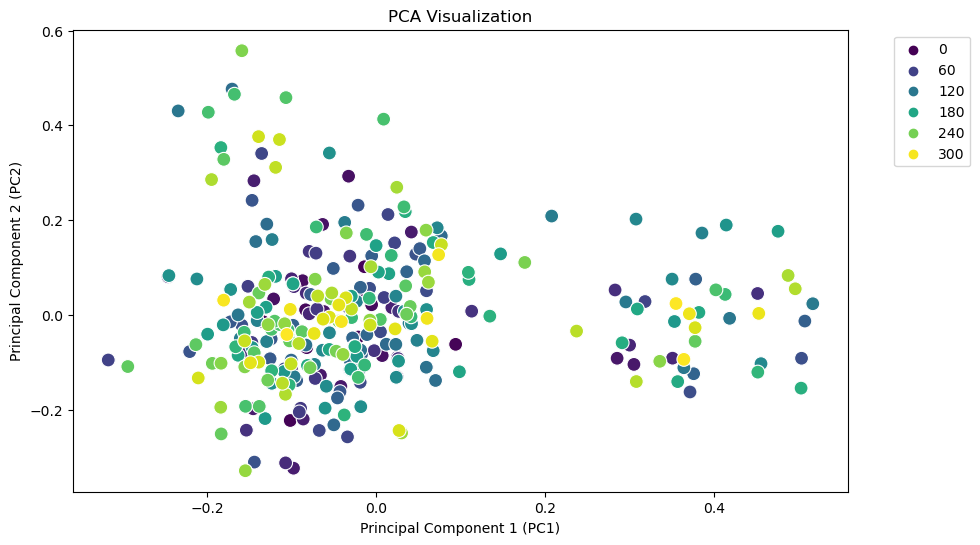

In [441]:

numeric_columns = df_features.loc[:, 'encod_1':'encod_128']

# Perform PCA
num_components = 2  # Choose the number of components for 2D visualization
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(numeric_columns)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the principal components DataFrame with the original DataFrame
df_result = pd.concat([df_features['ActorID'], df_pca], axis=1)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca.columns[0], y=df_pca.columns[1], data=df_result, hue='ActorID', palette='viridis', s=100)
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component 1 ({df_pca.columns[0]})')
plt.ylabel(f'Principal Component 2 ({df_pca.columns[1]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [439]:
numeric_columns

,ActorID,encod_1,encod_2,encod_3,encod_4,encod_5,encod_6,encod_7,encod_8,encod_9,...,actorID=295,actorID=296,actorID=297,actorID=298,actorID=299,actorID=300,actorID=301,actorID=302,actorID=303,actorID=304
1,1,-0.009848,0.174133,0.104025,-0.037406,-0.129088,0.124958,0.068162,-0.095914,0.151849,...,0.814402,0.928055,0.764257,0.853916,0.849672,0.809352,0.775537,0.864819,0.930477,0.878641
2,2,-0.189042,0.115545,0.054540,-0.078160,-0.118713,-0.006797,-0.025976,-0.014604,0.198822,...,0.992226,1.033064,0.861786,0.889529,0.867153,0.828516,0.866203,1.017925,0.923655,0.879467
3,3,-0.150220,0.107419,0.092116,0.026156,-0.131826,-0.024656,-0.017647,-0.046855,0.078582,...,0.830659,0.849908,0.747597,0.864113,0.792973,0.822257,0.808178,0.871117,0.875565,0.724267
4,4,-0.089153,0.103898,0.076538,-0.038232,-0.106986,-0.083717,-0.022531,-0.119116,0.096415,...,0.898604,0.883413,0.864941,0.741375,0.846811,0.783206,0.827357,0.936363,0.947498,0.802485
5,5,-0.057946,0.074479,0.006475,-0.100167,-0.105889,0.029007,-0.082072,-0.095677,0.129619,...,0.969817,0.790948,0.916121,0.734926,0.933313,0.717296,0.859467,0.965943,1.050591,0.875414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,123,-0.060393,0.084096,0.046128,-0.007324,-0.124708,0.017870,-0.055866,-0.082235,0.236702,...,0.811539,0.769578,0.786478,0.947895,0.854991,0.827426,0.963039,0.978461,0.799295,1.022008
124,124,-0.033291,0.100923,0.017282,-0.071899,-0.156913,-0.123446,0.003439,-0.077216,0.268711,...,0.695390,0.779838,0.834682,0.947186,0.860240,0.953666,1.113599,0.933169,0.717897,0.911098
125,125,-0.135973,0.163885,0.073992,-0.109955,-0.147741,-0.007543,-0.051199,-0.089523,0.162163,...,0.918405,1.016174,0.811057,0.819862,0.880620,0.809165,0.815849,1.081337,0.962966,0.855297
126,126,-0.022858,0.013161,0.100102,0.051656,-0.104927,-0.072677,-0.101880,-0.112923,0.112973,...,0.941332,0.940315,0.784235,0.849455,0.839181,0.780255,0.765633,1.113971,0.894000,0.821589
